# Extract the PSF  some stars in HD158485 field
=====================================================================

- Creation : Friday 2016 June 24th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

PSF of HD163466 with grating


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [3]:
#photutils.test()

In [4]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [5]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [6]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-14 12:16:34.599690
fits date format for the analysis :  2016-07-14T12:16:34


In [71]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    
    theweights=np.where(weights>0, weights ,0)
    average = np.average(values, weights=theweights)
    variance = np.average((values-average)**2, weights=theweights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [90]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## 3) Configuration of the input file

- HD158485_grat_science.fits
- HD159222_grat_science.fits
- HD163466_grat_science.fits


In [7]:
#object_name='HD158485_grat_20'
#object_name='HD159222_grat'
object_name='HD158485_grat'

In [8]:
path='./HD158485_grat'
basefilename='AssScImHD158485_grat_107.fits' # check master bias
filename=os.path.join(path,basefilename)

## 4) Read the images

In [9]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data

## 5) Shows the images

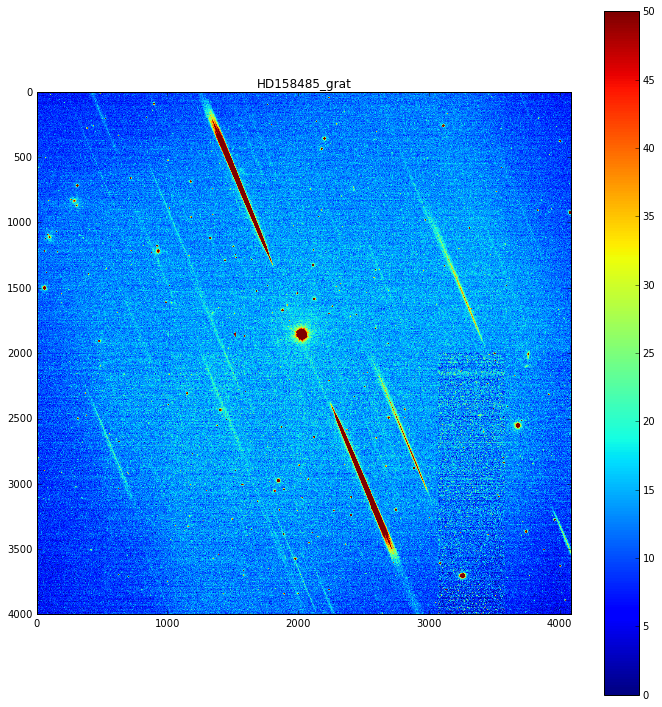

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [11]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [12]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 13.132388712947414)
('median rms = ', 2.8772662881382414)


### Radiography of the residual background

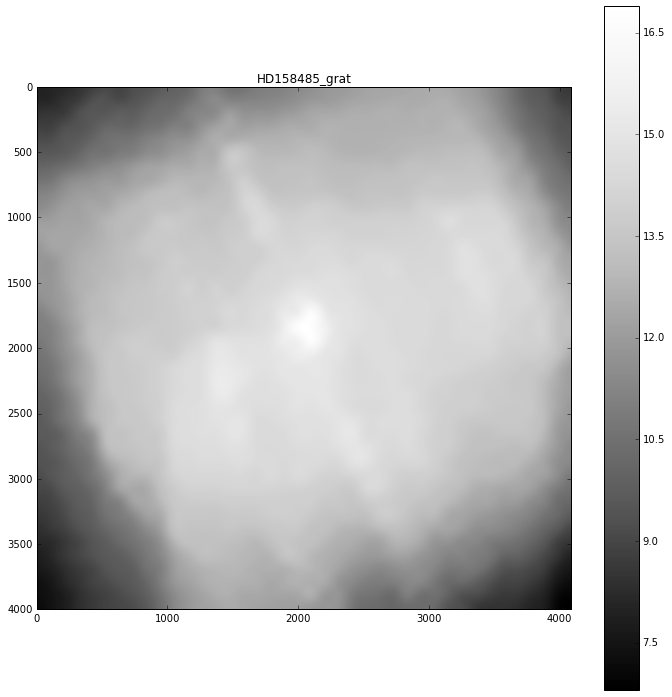

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract residual the background

In [14]:
data2=data - bkg.background

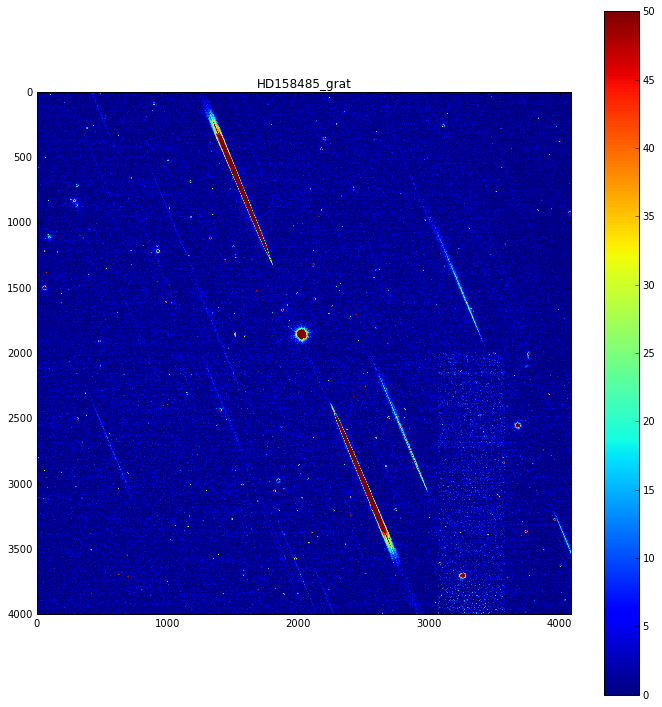

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [16]:
mean, median, std = sigma_clipped_stats(data2, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.0094159108579976759, -0.14145856166108839, 3.5197659646901056)


In [17]:
sources = daofind(data2 - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      peak          flux           mag       
--- ------------- ------------- ... ------------- ------------- ----------------
  9 4072.08699233 933.677058699 ... 786.115503519 1.03625100817 -0.0386624152155
 14 1437.43875221 1294.88698189 ...  483.84077147  1.0684188806 -0.0718538851686
 33 2117.73596027 2644.60590819 ... 532.389527213 1.07417758329 -0.0776902124141
 11 918.449878272 1182.34631613 ... 564.424753574 1.07820367253 -0.0817520169256
  5 715.627354817 664.541309676 ... 525.996213321 1.16772093944  -0.168347669994
 34 2879.93400056 2882.57611581 ... 612.324115886 1.17071950323  -0.171132133512
 44 3997.47983644 3629.52192627 ... 527.934652116 1.17825566075  -0.178098837349
 31 310.935323653 2504.08867405 ... 614.637494985 1.46394568733   -0.41381241153
  4  2175.2167748 440.465450922 ... 863.574821108 1.64568192701  -0.540864749286
 42 1974.80011996 3575.87840575 ... 884.164642718  1.7793964687  -0.625681810889
...           ...           

In [18]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,4072.08699233,933.677058699,0.48271445761,0.822373591817,0.809941558657,25.0,0.0,786.115503519,1.03625100817,-0.0386624152155
14,1437.43875221,1294.88698189,0.379147052447,0.0965465676794,-0.11001750514,25.0,0.0,483.84077147,1.0684188806,-0.0718538851686
33,2117.73596027,2644.60590819,0.372191989565,0.124371626329,-0.088003024519,25.0,0.0,532.389527213,1.07417758329,-0.0776902124141
11,918.449878272,1182.34631613,0.432493120607,-0.123040790206,-0.086850806978,25.0,0.0,564.424753574,1.07820367253,-0.0817520169256
5,715.627354817,664.541309676,0.390478745745,-0.149790777775,-0.285408467568,25.0,0.0,525.996213321,1.16772093944,-0.168347669994
34,2879.93400056,2882.57611581,0.386426550901,0.0649141806353,-0.193942044281,25.0,0.0,612.324115886,1.17071950323,-0.171132133512
44,3997.47983644,3629.52192627,0.38739603248,-0.0780049942242,-0.311221719609,25.0,0.0,527.934652116,1.17825566075,-0.178098837349
31,310.935323653,2504.08867405,0.412124171975,0.158075301567,-0.300764188137,25.0,0.0,614.637494985,1.46394568733,-0.41381241153
4,2175.2167748,440.465450922,0.409773683145,-0.120176536721,-0.134479807465,25.0,0.0,863.574821108,1.64568192701,-0.540864749286


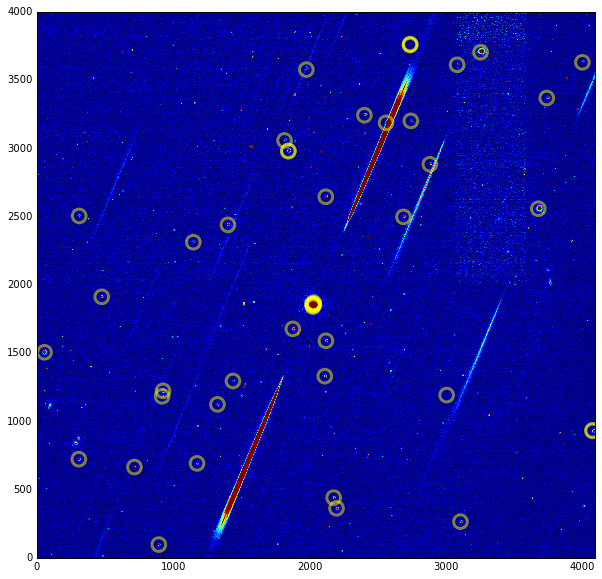

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(data2,vmin=0,vmax=50.,origin='lower')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='yellow', lw=3., alpha=0.5)

### For example shows the 25 first stars

In [20]:
NBSTARS=25
XX=np.zeros(NBSTARS)
YY=np.zeros(NBSTARS)



selected_stars=sources.as_array()
NBFOUNDSTARS=np.min([NBSTARS,selected_stars.shape[0]])

for istar in range(NBFOUNDSTARS):
    XX[istar] = int(selected_stars[istar][1])
    YY[istar] = int(selected_stars[istar][2])   
    print XX[istar],YY[istar]

4072.0 933.0
1437.0 1294.0
2117.0 2644.0
918.0 1182.0
715.0 664.0
2879.0 2882.0
3997.0 3629.0
310.0 2504.0
2175.0 440.0
1974.0 3575.0
1174.0 691.0
3079.0 3611.0
2735.0 3763.0
2686.0 2497.0
1815.0 3057.0
2740.0 3200.0
2735.0 3759.0
1146.0 2311.0
2400.0 3242.0
3002.0 1191.0
2109.0 1330.0
1324.0 1123.0
894.0 96.0
3104.0 264.0
1875.0 1676.0


## Work with one PSF of one star

In [84]:
# Extract the plot of a PSF
index=24

onepsf=data2[YY[index]-10:YY[index]+10,XX[index]-10:XX[index]+10]
onepsfX=onepsf.sum(axis=0)
onepsfY=onepsf.sum(axis=1)

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


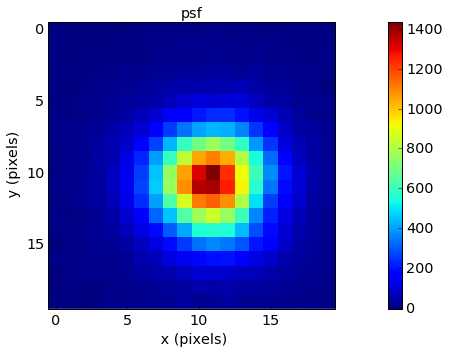

In [100]:
figname='psf_img.pdf'
im=plt.imshow(onepsf,interpolation='None')
#im=plt.imshow(onepsf)
plt.colorbar(im)
plt.title('psf')
plt.xlabel(' x (pixels)')
plt.ylabel(' y (pixels)')
plt.tight_layout()
plt.savefig(figname,bbox_inches='tight')

In [92]:
(mx,sigx)=weighted_avg_and_std(np.arange(onepsfX.shape[0]),onepsfX)
(my,sigy)=weighted_avg_and_std(np.arange(onepsfY.shape[0]),onepsfY)

In [94]:
labelx='$\sigma$(psfx)={:2.2f} pix'.format(sigx)
labely='$\sigma$(psfy)={:2.2f} pix'.format(sigy)

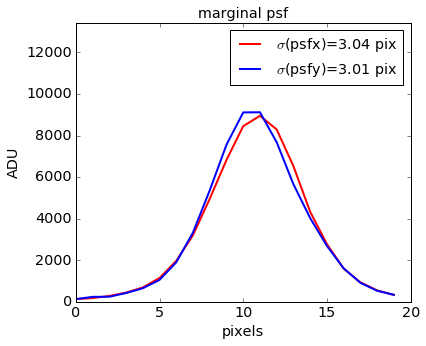

In [99]:
plt.figure(figsize=(6,5))
figname='psfxpsfy.pdf'
plt.plot(onepsfX,'r',linewidth=2,label=labelx)
plt.plot(onepsfY,'b',linewidth=2,label=labely)
plt.ylim(0.,onepsfX.max()*1.5)
plt.title('marginal psf')
plt.xlabel('pixels')
plt.ylabel('ADU')
plt.legend(loc='best')
plt.savefig(figname,bbox_inches='tight')

In [67]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    
    theweights=np.where(weights>0, weights ,0)
    average = np.average(values, weights=theweights)
    variance = np.average((values-average)**2, weights=theweights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [68]:
DELTA_NBINSX=10
DELTA_NBINSY=10

In [69]:
weighted_avg_and_std(np.arange(onepsfX.shape[0]),onepsfX)

(10.726574565480915, 2.8638783169679511)

In [70]:
weighted_avg_and_std(np.arange(onepsfY.shape[0]),onepsfY)

(10.284522193622422, 2.9403889651800035)

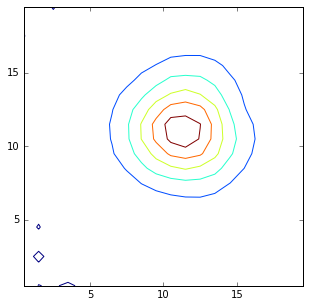

In [89]:
plt.figure(figsize=(5,5))
#onepsf2 = onepsf / np.linalg.norm(onepsf, axis=-1)[:, np.newaxis]
onepsf2 = onepsf / np.sum(onepsf)
levels=np.array([1,0.682,0.75,0.89,0.94,0.96,0.97])
#plt.contour(onepsf2,levels=levels,origin='lower') matmpltlib bug
plt.contour(onepsf2,origin='lower')

In [29]:
XV=np.arange(2*DELTA_NBINSX)-DELTA_NBINSX
YV=np.arange(2*DELTA_NBINSY)-DELTA_NBINSY
Xgrid,Ygrid=np.meshgrid(XV,YV)

In [30]:
weighted_avg_and_std(Xgrid,onepsf2)

(-0.18910770899320989, 3.1220715060648483)

In [31]:
weighted_avg_and_std(Ygrid,onepsf2)

(-3.0505433441766772, 3.3256083108237702)

### Estimation of PRF (PSF) for a bunch of stars


I could not use any of the utilities function.
It lacks of working examples

In [32]:
import photutils.psf 
from photutils.psf import psf_photometry

In [33]:
from astropy.modeling import models, fitting

In [34]:
import photutils
from photutils import psf

photutils.__version__

u'0.3.dev1833'

### Extraction of a few stars for visualization

In [35]:
DELTA_NBINSX=10
DELTA_NBINSY=10

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


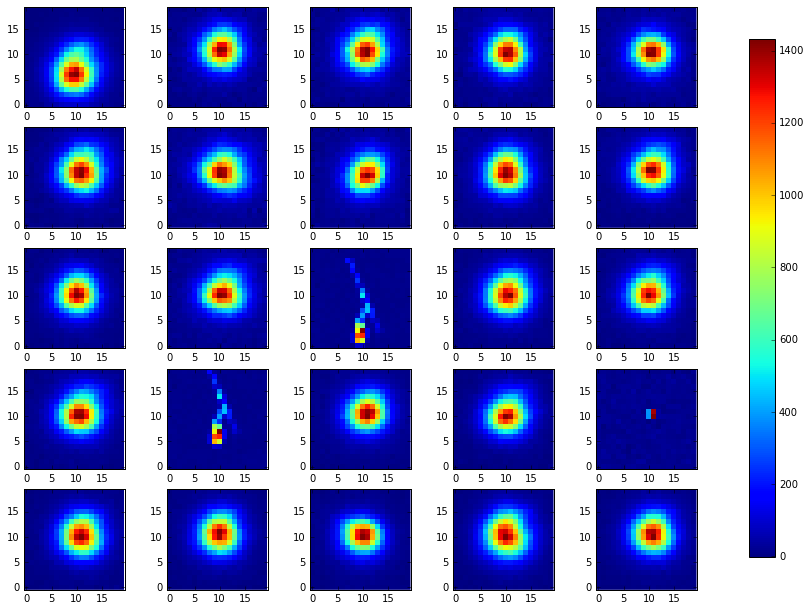

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(12, 9)
# Plot kernels
for i in range(5):
    for j in range(5):
        index=5*i+j
        if index <NBFOUNDSTARS :
            prf_image = data2[YY[index]-DELTA_NBINSY:YY[index]+DELTA_NBINSY,XX[index]-DELTA_NBINSX:XX[index]+DELTA_NBINSX]
            im = axes[i, j].imshow(prf_image, interpolation='None',origin='lower')
			
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.show()

In [37]:
selected_stars=sources.as_array()

NB_OF_STARS=selected_stars.shape[0]
SIGMAX_OF_STARS=np.zeros(NB_OF_STARS)
SIGMAY_OF_STARS=np.zeros(NB_OF_STARS)
for istar in range(selected_stars.shape[0]):
    XXs = int(selected_stars[istar][1])
    YYs = int(selected_stars[istar][2])   
    star_image = data2[YYs-DELTA_NBINSY:YYs+DELTA_NBINSY,XXs-DELTA_NBINSX:XXs+DELTA_NBINSX]
    thepsf = star_image / np.sum(star_image)
    SIGMAX_OF_STARS[istar]=weighted_avg_and_std(Xgrid,thepsf)[1]
    SIGMAY_OF_STARS[istar]=weighted_avg_and_std(Ygrid,thepsf)[1]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


In [38]:
SIGMAX_OF_STARS

array([ 3.12207151,  2.97409539,  3.08029634,  2.96044464,  2.96370824,
        3.11559043,  3.17760398,  2.86387832,  3.07840089,  3.17979328,
        2.98284224,  3.09006342,  0.58661636,  3.12190702,  3.04119816,
        3.10944888,  0.7690875 ,  2.99896259,  3.07013153,         nan,
        3.05009078,  3.0368289 ,  2.97112054,  3.14599826,  3.03529167,
        3.66174474,  2.89291125,  3.22931728,  3.06581775,  3.11793529,
        3.03998135,  3.39265536,  2.99987888,  3.45179716,  3.42192882,
        2.92090302,  0.78682302,  2.95822321,  2.858528  ,  3.21776289,
        3.4769702 ,  3.6018534 ,  3.20791908,  3.52031888,  3.75846599,
        3.64597647,  2.58195626,  2.01782505])

In [39]:
SIGMAY_OF_STARS

array([ 3.32560831,  2.95413873,  3.11307934,  3.05799786,  2.89425435,
        3.14569725,  2.89286585,  2.94038897,  3.10203983,  3.07435136,
        3.01603031,  2.99493069,  3.87876512,  3.1227931 ,  3.04890157,
        3.13216972,  3.4332941 ,  2.96595291,  3.03450987,         nan,
        3.0564282 ,  3.06163236,  2.76369487,  3.21558617,  3.01056711,
        5.4240629 ,  2.93454128,  3.03008535,  3.03883472,  3.34971591,
        3.10800532,  3.73232912,  3.01764815,  3.10485214,  3.10070696,
        2.8031722 ,  2.67974333,  3.02167237,  2.93774212,  3.23321619,
        5.491821  ,  5.41933414,  2.98171224,  5.50411936,  5.36205999,
        5.38428583,  5.12450941,  4.38248334])

#### Cut NAN

In [40]:
all_sigx=SIGMAX_OF_STARS[np.logical_not(np.isnan(SIGMAX_OF_STARS))]
all_sigy=SIGMAY_OF_STARS[np.logical_not(np.isnan(SIGMAY_OF_STARS))]

#### Cut too low values

In [41]:
all_sigx=all_sigx[all_sigx>2.0]
all_sigy=all_sigy[all_sigy>2.0]

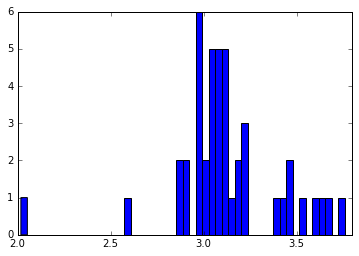

In [42]:
h1=plt.hist(all_sigx,50)

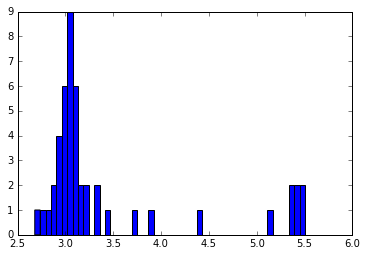

In [43]:
h1=plt.hist(all_sigy,50)

In [44]:
all_sigx.mean()

3.1184190296849108

In [45]:
print 'average prf(x) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(all_sigx.mean(),all_sigx.std(),all_sigx.mean()*0.4*2.36,all_sigx.std()*0.4*2.26)
print 'average prf(y) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(all_sigy.mean(),all_sigy.std(),all_sigy.mean()*0.4*2.36,all_sigy.std()*0.4*2.26)

average prf(x) = 3.12 +/- 0.29 pixels ==> psf  2.94 +/- 0.26 arcsec 
average prf(y) = 3.46 +/- 0.85 pixels ==> psf  3.26 +/- 0.77 arcsec 


In [46]:
print 'average prf(x) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigx),all_sigx.std(),np.median(all_sigx)*0.4*2.36,all_sigx.std()*0.4*2.26)
print 'average prf(y) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigy),all_sigy.std(),np.median(all_sigy)*0.4*2.36,all_sigy.std()*0.4*2.26)

average prf(x) = 3.08 +/- 0.29 pixels ==> psf  2.91 +/- 0.26 arcsec 
average prf(y) = 3.07 +/- 0.85 pixels ==> psf  2.90 +/- 0.77 arcsec 
